# B-P Phoneme Classification Model Training

Training ML models for /b/ vs /p/ phoneme classification:
- Load and preprocess data
- Define feature sets (5 different combinations)
- Normalize features (StandardScaler and MinMaxScaler)
- Train 5 models with cross-validation
- Evaluate with comprehensive metrics
- Visualize results
- Save models and results

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             cohen_kappa_score, matthews_corrcoef)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
import joblib
from joblib import Parallel, delayed
import json
from datetime import datetime
import os

# Configuration
PROJECT_ROOT = Path('/Volumes/SSanDisk/SpeechRec-German/without_context_windows')
DATA_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_dataset' / 'features'
OUTPUT_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_models'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Create subdirectories
(OUTPUT_DIR / 'models').mkdir(exist_ok=True)
(OUTPUT_DIR / 'scalers').mkdir(exist_ok=True)
(OUTPUT_DIR / 'results').mkdir(exist_ok=True)
(OUTPUT_DIR / 'plots').mkdir(exist_ok=True)
(OUTPUT_DIR / 'report').mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Project root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

Project root: /Volumes/SSanDisk/SpeechRec-German
Output directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models


## 1. Load and Preprocess Data

In [2]:
# Load data
print("Loading data...")
df = pd.read_parquet(DATA_DIR / 'features.parquet')

print(f"Loaded {len(df):,} samples")
print(f"Columns: {len(df.columns)}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nClass distribution (%):")
print(df['class'].value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Separate features and target
# Exclude non-feature columns
exclude_cols = ['phoneme_id', 'class', 'is_outlier_iso']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df['class'].copy()

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # b=0, p=1

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Check for zero variance features
zero_var_cols = X.columns[X.var() == 0].tolist()
if zero_var_cols:
    print(f"\nZero variance features (will be removed): {len(zero_var_cols)}")
    print(zero_var_cols[:10])
    X = X.drop(columns=zero_var_cols)
    feature_cols = [col for col in feature_cols if col not in zero_var_cols]

print(f"\nFinal features shape: {X.shape}")

Loading data...
Loaded 36,799 samples
Columns: 112

Class distribution:
class
b    24917
p    11882
Name: count, dtype: int64

Class distribution (%):
class
b    67.711079
p    32.288921
Name: proportion, dtype: float64

Missing values:
harmonic_noise_ratio    9948
dtype: int64

Features shape: (36799, 109)
Target shape: (36799,)
Target encoding: {'b': np.int64(0), 'p': np.int64(1)}

Final features shape: (36799, 109)


In [3]:
# Train/Val/Test split (70/15/15) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=RANDOM_STATE, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE, stratify=y_temp  # 0.176 ≈ 15/85
)

print(f"Train set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"Val set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Class distribution: {np.bincount(y_val)}")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Class distribution: {np.bincount(y_test)}")

# Check class imbalance
train_class_dist = np.bincount(y_train)
print(f"\nClass imbalance in train set:")
print(f"  /b/ (0): {train_class_dist[0]:,} ({train_class_dist[0]/len(y_train)*100:.1f}%)")
print(f"  /p/ (1): {train_class_dist[1]:,} ({train_class_dist[1]/len(y_train)*100:.1f}%)")
print(f"  Ratio: {train_class_dist[0]/train_class_dist[1]:.2f}:1")

Train set: 25,773 samples (70.0%)
  Class distribution: [17451  8322]
Val set: 5,506 samples (15.0%)
  Class distribution: [3728 1778]
Test set: 5,520 samples (15.0%)
  Class distribution: [3738 1782]

Class imbalance in train set:
  /b/ (0): 17,451 (67.7%)
  /p/ (1): 8,322 (32.3%)
  Ratio: 2.10:1


## 2. Define Feature Sets

In [4]:
def get_feature_set_1(X):
    """Set 1: Basic - MFCC[0-3] + F1, F2 + Duration"""
    features = [f'mfcc_mean_{i}' for i in range(4)]
    features.extend(['formant_f1', 'formant_f2', 'duration_ms'])
    # Filter to only existing columns
    features = [f for f in features if f in X.columns]
    return X[features]

def get_feature_set_2(X):
    """Set 2: Extended - Set 1 + Delta MFCC + RMS Energy"""
    features = list(get_feature_set_1(X).columns)
    features.extend([f'delta_mfcc_mean_{i}' for i in range(4)])
    features.append('energy_rms')
    # Filter to only existing columns
    features = [f for f in features if f in X.columns]
    return X[features]

def get_feature_set_3(X):
    """Set 3: Full - Set 2 + Spectral Features"""
    features = list(get_feature_set_2(X).columns)
    features.extend(['spectral_centroid', 'spectral_bandwidth'])
    # Add first few spectral contrast features
    contrast_features = [f'spectral_contrast_mean_{i}' for i in range(7)]
    features.extend([f for f in contrast_features if f in X.columns])
    # Filter to only existing columns
    features = [f for f in features if f in X.columns]
    return X[features]

def get_feature_set_4(X):
    """Set 4: Full without multicollinearity - Set 3 without spectral_centroid"""
    features = list(get_feature_set_3(X).columns)
    # Remove spectral_centroid (high correlation with mfcc_mean_1)
    if 'spectral_centroid' in features:
        features.remove('spectral_centroid')
    return X[features]

def get_feature_set_5(X):
    """Set 5: All features"""
    return X

def handle_nan_features(X_train_fs, X_val_fs, X_test_fs):
    """Handle NaN values in feature sets: remove all-NaN columns, fill remaining with median"""
    # Remove columns with all NaN in train set
    nan_cols_train = X_train_fs.columns[X_train_fs.isnull().all()].tolist()
    if nan_cols_train:
        X_train_fs = X_train_fs.drop(columns=nan_cols_train)
        X_val_fs = X_val_fs.drop(columns=nan_cols_train)
        X_test_fs = X_test_fs.drop(columns=nan_cols_train)
    
    # Fill remaining NaN with median (computed on train set only)
    if X_train_fs.isnull().any().any():
        medians = X_train_fs.median()
        X_train_fs = X_train_fs.fillna(medians)
        X_val_fs = X_val_fs.fillna(medians)
        X_test_fs = X_test_fs.fillna(medians)
    
    return X_train_fs, X_val_fs, X_test_fs

# Test feature sets
print("Feature set sizes:")
feature_sets = {
    'Set 1: Basic': get_feature_set_1(X_train),
    'Set 2: Extended': get_feature_set_2(X_train),
    'Set 3: Full': get_feature_set_3(X_train),
    'Set 4: Full (no multicollinearity)': get_feature_set_4(X_train),
    'Set 5: All features': get_feature_set_5(X_train)
}

for name, X_set in feature_sets.items():
    print(f"  {name}: {X_set.shape[1]} features")
    if len(X_set.columns) > 10:
        print(f"    Features: {list(X_set.columns[:10])}...")
    else:
        print(f"    Features: {list(X_set.columns)}")

Feature set sizes:
  Set 1: Basic: 7 features
    Features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'formant_f1', 'formant_f2', 'duration_ms']
  Set 2: Extended: 12 features
    Features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'formant_f1', 'formant_f2', 'duration_ms', 'delta_mfcc_mean_0', 'delta_mfcc_mean_1', 'delta_mfcc_mean_2']...
  Set 3: Full: 21 features
    Features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'formant_f1', 'formant_f2', 'duration_ms', 'delta_mfcc_mean_0', 'delta_mfcc_mean_1', 'delta_mfcc_mean_2']...
  Set 4: Full (no multicollinearity): 20 features
    Features: ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'formant_f1', 'formant_f2', 'duration_ms', 'delta_mfcc_mean_0', 'delta_mfcc_mean_1', 'delta_mfcc_mean_2']...
  Set 5: All features: 109 features
    Features: ['energy_rms', 'energy_rms_std', 'energy_zcr', 'energy_zcr_std', 'spectral_centroid', 'spectral_centroid_std', 'spectral_rollo

In [5]:
# Import Parallel and delayed for parallelization
from joblib import Parallel, delayed
import os

# Function to train a single model combination (for parallel execution)
def train_single_combination(feature_set_name, feature_func, scaler_name, scaler, model_name, model, 
                             X_train, X_val, X_test, y_train, y_val, y_test, calculate_all_metrics):
    """
    Train a single model combination (feature_set + scaler + model).
    This function is designed to be called in parallel.
    """
    try:
        # Get feature sets
        X_train_fs = feature_func(X_train)
        X_val_fs = feature_func(X_val)
        X_test_fs = feature_func(X_test)
        
        # Handle NaN values
        nan_cols_before = X_train_fs.isnull().all().sum()
        
        # Remove columns with all NaN in train set
        nan_cols_train = X_train_fs.columns[X_train_fs.isnull().all()].tolist()
        if nan_cols_train:
            X_train_fs = X_train_fs.drop(columns=nan_cols_train)
            X_val_fs = X_val_fs.drop(columns=nan_cols_train)
            X_test_fs = X_test_fs.drop(columns=nan_cols_train)
        
        # Fill remaining NaN with median (computed on train set only)
        if X_train_fs.isnull().any().any():
            medians = X_train_fs.median()
            X_train_fs = X_train_fs.fillna(medians)
            X_val_fs = X_val_fs.fillna(medians)
            X_test_fs = X_test_fs.fillna(medians)
        
        # Fit scaler on train only
        scaler_fitted = scaler.__class__()
        X_train_scaled = scaler_fitted.fit_transform(X_train_fs)
        X_val_scaled = scaler_fitted.transform(X_val_fs)
        X_test_scaled = scaler_fitted.transform(X_test_fs)
        
        # Adjust n_jobs for cross-validation to avoid overloading
        # When parallelizing at outer level, use 1 job for inner CV to avoid nested parallelism
        # Adjust model n_jobs if it's RandomForest or other models that support it
        model_params = model.get_params().copy()
        if 'n_jobs' in model_params and model_params['n_jobs'] == -1:
            # Use 1 job for models when parallelizing outer loop
            model_params['n_jobs'] = 1
        
        # Create model instance with adjusted parameters for CV
        model_for_cv = model.__class__(**model_params)
        
        # Cross-validation with n_jobs=1 to avoid nested parallelism issues
        from sklearn.model_selection import cross_val_score
        cv_scores = cross_val_score(
            model_for_cv, X_train_scaled, y_train, 
            cv=5, scoring='accuracy', n_jobs=1
        )
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Train on full training set (use same adjusted parameters)
        model_fitted = model.__class__(**model_params)
        model_fitted.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred_train = model_fitted.predict(X_train_scaled)
        y_pred_val = model_fitted.predict(X_val_scaled)
        y_pred_test = model_fitted.predict(X_test_scaled)
        
        # Probabilities
        y_proba_train = model_fitted.predict_proba(X_train_scaled)
        y_proba_val = model_fitted.predict_proba(X_val_scaled)
        y_proba_test = model_fitted.predict_proba(X_test_scaled)
        
        # Calculate metrics
        metrics = calculate_all_metrics(
            y_train, y_pred_train, y_proba_train,
            y_val, y_pred_val, y_proba_val,
            y_test, y_pred_test, y_proba_test
        )
        
        # Add metadata
        metrics['model'] = model_name
        metrics['feature_set'] = feature_set_name
        metrics['scaler'] = scaler_name
        metrics['cv_mean'] = cv_mean
        metrics['cv_std'] = cv_std
        metrics['n_features'] = X_train_fs.shape[1]
        
        # Return results
        key = f"{model_name}_{feature_set_name}_{scaler_name}"
        return {
            'success': True,
            'key': key,
            'metrics': metrics,
            'model': model_fitted,
            'scaler': scaler_fitted,
            'message': f"✓ {model_name} ({feature_set_name}, {scaler_name}): Test Acc={metrics['test_accuracy']:.4f} (CV: {cv_mean:.4f} ± {cv_std:.4f})"
        }
        
    except Exception as e:
        return {
            'success': False,
            'key': f"{model_name}_{feature_set_name}_{scaler_name}",
            'error': str(e),
            'message': f"✗ {model_name} ({feature_set_name}, {scaler_name}): Error - {str(e)}"
        }

print("Parallel training function defined.")

Parallel training function defined.


## 3. Metrics Calculation Function

In [6]:
def calculate_all_metrics(y_true_train, y_pred_train, y_proba_train,
                          y_true_val, y_pred_val, y_proba_val,
                          y_true_test, y_pred_test, y_proba_test):
    """Calculate all metrics for train/val/test sets"""
    metrics = {}
    
    for split_name, y_true, y_pred, y_proba in [
        ('train', y_true_train, y_pred_train, y_proba_train),
        ('val', y_true_val, y_pred_val, y_proba_val),
        ('test', y_true_test, y_pred_test, y_proba_test)
    ]:
        # Basic metrics
        metrics[f'{split_name}_accuracy'] = accuracy_score(y_true, y_pred)
        metrics[f'{split_name}_precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics[f'{split_name}_recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        metrics[f'{split_name}_f1'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Per-class metrics
        precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
        
        metrics[f'{split_name}_precision_b'] = precision_per_class[0]
        metrics[f'{split_name}_precision_p'] = precision_per_class[1]
        metrics[f'{split_name}_recall_b'] = recall_per_class[0]
        metrics[f'{split_name}_recall_p'] = recall_per_class[1]
        metrics[f'{split_name}_f1_b'] = f1_per_class[0]
        metrics[f'{split_name}_f1_p'] = f1_per_class[1]
        
        # ROC-AUC
        try:
            metrics[f'{split_name}_roc_auc'] = roc_auc_score(y_true, y_proba[:, 1])
        except:
            metrics[f'{split_name}_roc_auc'] = 0.0
        
        # Precision-Recall AUC
        try:
            metrics[f'{split_name}_pr_auc'] = average_precision_score(y_true, y_proba[:, 1])
        except:
            metrics[f'{split_name}_pr_auc'] = 0.0
        
        # Cohen's Kappa
        metrics[f'{split_name}_kappa'] = cohen_kappa_score(y_true, y_pred)
        
        # Matthews Correlation Coefficient
        metrics[f'{split_name}_mcc'] = matthews_corrcoef(y_true, y_pred)
        
        # Confusion matrix
        metrics[f'{split_name}_confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
        
    return metrics

## 4. Model Training with Cross-Validation

In [7]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'  # Handle class imbalance
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        n_estimators=100
    ),
    'SVM': SVC(
        probability=True,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        kernel='rbf'
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1
    )
}

print("Models defined:")
for name, model in models.items():
    print(f"  {name}: {type(model).__name__}")

Models defined:
  LogisticRegression: LogisticRegression
  RandomForest: RandomForestClassifier
  GradientBoosting: GradientBoostingClassifier
  SVM: SVC
  MLP: MLPClassifier


In [8]:
# Storage for results
all_results = []
trained_models = {}
trained_scalers = {}

# Feature set functions mapping
feature_set_funcs = {
    'Set 1: Basic': get_feature_set_1,
    'Set 2: Extended': get_feature_set_2,
    'Set 3: Full': get_feature_set_3,
    'Set 4: Full (no multicollinearity)': get_feature_set_4,
    'Set 5: All features': get_feature_set_5
}

# Scalers to test
scalers_to_test = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

print("Starting model training...")
print(f"Total combinations: {len(feature_set_funcs)} feature sets × {len(models)} models × {len(scalers_to_test)} scalers = {len(feature_set_funcs) * len(models) * len(scalers_to_test)}")
print()

Starting model training...
Total combinations: 5 feature sets × 5 models × 2 scalers = 50



In [9]:
# Train models in parallel for all combinations
print("Starting parallel model training...")
print(f"Total combinations: {len(feature_set_funcs)} feature sets × {len(models)} models × {len(scalers_to_test)} scalers = {len(feature_set_funcs) * len(models) * len(scalers_to_test)}")
print()

# Create list of all combinations to train
combinations = []
for feature_set_name, feature_func in feature_set_funcs.items():
    for scaler_name, scaler in scalers_to_test.items():
        for model_name, model in models.items():
            combinations.append((feature_set_name, feature_func, scaler_name, scaler, model_name, model))

# Determine number of parallel jobs
# Use all available CPUs, but leave some for system
import multiprocessing
n_jobs_parallel = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {n_jobs_parallel} parallel workers for training...")
print()

# Train all combinations in parallel
results = Parallel(n_jobs=n_jobs_parallel, verbose=10)(
    delayed(train_single_combination)(
        feature_set_name, feature_func, scaler_name, scaler, model_name, model,
        X_train, X_val, X_test, y_train, y_val, y_test, calculate_all_metrics
    )
    for feature_set_name, feature_func, scaler_name, scaler, model_name, model in combinations
)

# Process results
print("\n" + "="*80)
print("Processing results...")
print("="*80)

successful_count = 0
for result in results:
    if result['success']:
        all_results.append(result['metrics'])
        trained_models[result['key']] = result['model']
        trained_scalers[result['key']] = result['scaler']
        successful_count += 1
        print(result['message'])
    else:
        print(result['message'])

print(f"\n\nTraining completed! Total models trained: {successful_count}/{len(combinations)}")
print(f"Successful: {successful_count}, Failed: {len(combinations) - successful_count}")

Starting parallel model training...
Total combinations: 5 feature sets × 5 models × 2 scalers = 50

Using 7 parallel workers for training...



[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


KeyboardInterrupt: 

## 5. Results Analysis and Visualization

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Display summary
print("Results Summary:")
print(f"Total models: {len(results_df)}")
print(f"\nTop 10 models by test accuracy:")
top_10 = results_df.nlargest(10, 'test_accuracy')[
    ['model', 'feature_set', 'scaler', 'test_accuracy', 'test_f1', 'test_roc_auc', 'cv_mean', 'cv_std']
]
print(top_10.to_string(index=False))

# Save results to CSV
results_df.to_csv(OUTPUT_DIR / 'results' / 'all_results.csv', index=False)
print(f"\nResults saved to: {OUTPUT_DIR / 'results' / 'all_results.csv'}")

Results Summary:
Total models: 50

Top 10 models by test accuracy:
       model                        feature_set         scaler  test_accuracy  test_f1  test_roc_auc  cv_mean   cv_std
         MLP                Set 5: All features   MinMaxScaler       0.940036 0.939738      0.983207 0.932410 0.004918
         SVM                Set 5: All features StandardScaler       0.939855 0.940150      0.983533 0.937144 0.002661
         MLP                Set 5: All features StandardScaler       0.937681 0.937607      0.983126 0.941024 0.003558
         MLP                        Set 3: Full StandardScaler       0.936775 0.936560      0.977459 0.929500 0.003588
         MLP Set 4: Full (no multicollinearity) StandardScaler       0.930797 0.930673      0.977083 0.926668 0.005292
         MLP Set 4: Full (no multicollinearity)   MinMaxScaler       0.928623 0.928251      0.974999 0.921352 0.003034
         SVM                        Set 3: Full StandardScaler       0.927899 0.928503      0.976620

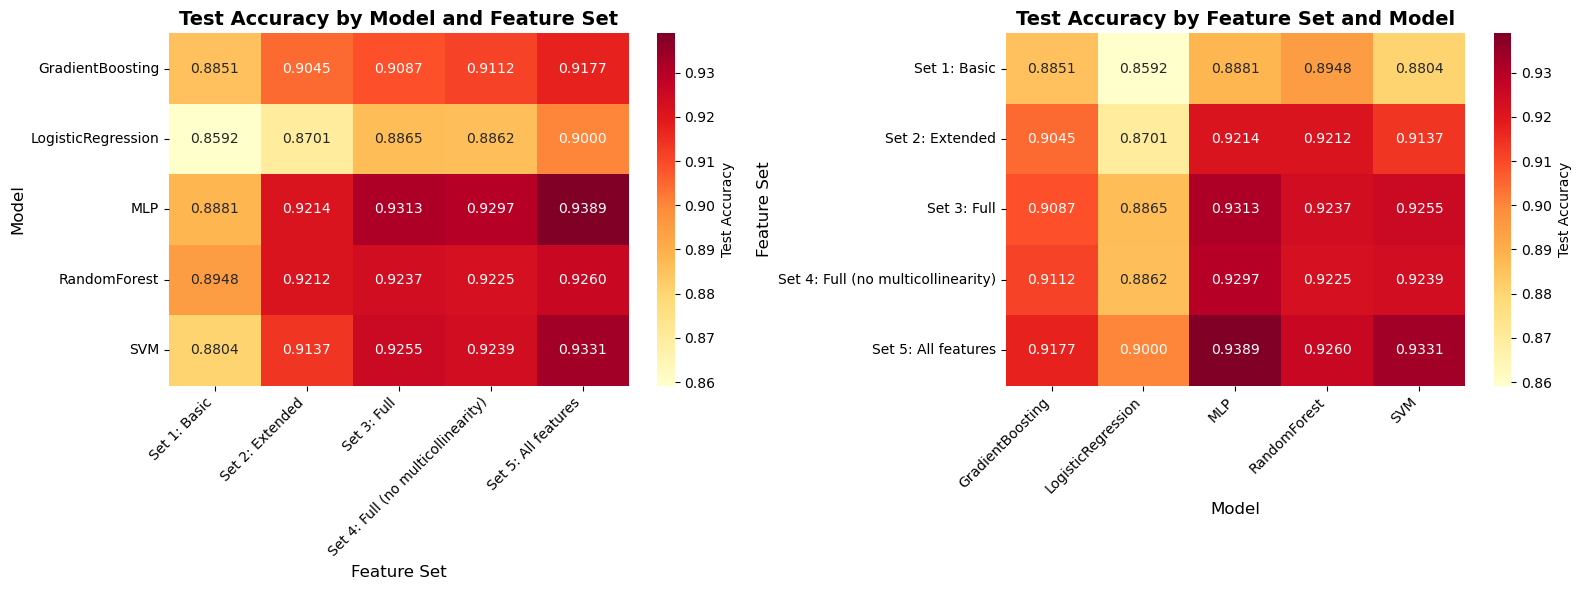

Accuracy comparison plot saved.


In [ ]:
# 1. Accuracy Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By model
ax1 = axes[0]
results_pivot_model = results_df.pivot_table(
    values='test_accuracy', 
    index='model', 
    columns='feature_set', 
    aggfunc='mean'
)
sns.heatmap(results_pivot_model, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Test Accuracy'})
ax1.set_title('Test Accuracy by Model and Feature Set', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature Set', fontsize=12)
ax1.set_ylabel('Model', fontsize=12)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# By feature set
ax2 = axes[1]
results_pivot_fs = results_df.pivot_table(
    values='test_accuracy', 
    index='feature_set', 
    columns='model', 
    aggfunc='mean'
)
sns.heatmap(results_pivot_fs, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Test Accuracy'})
ax2.set_title('Test Accuracy by Feature Set and Model', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Feature Set', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'plots' / 'accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Accuracy comparison plot saved.")

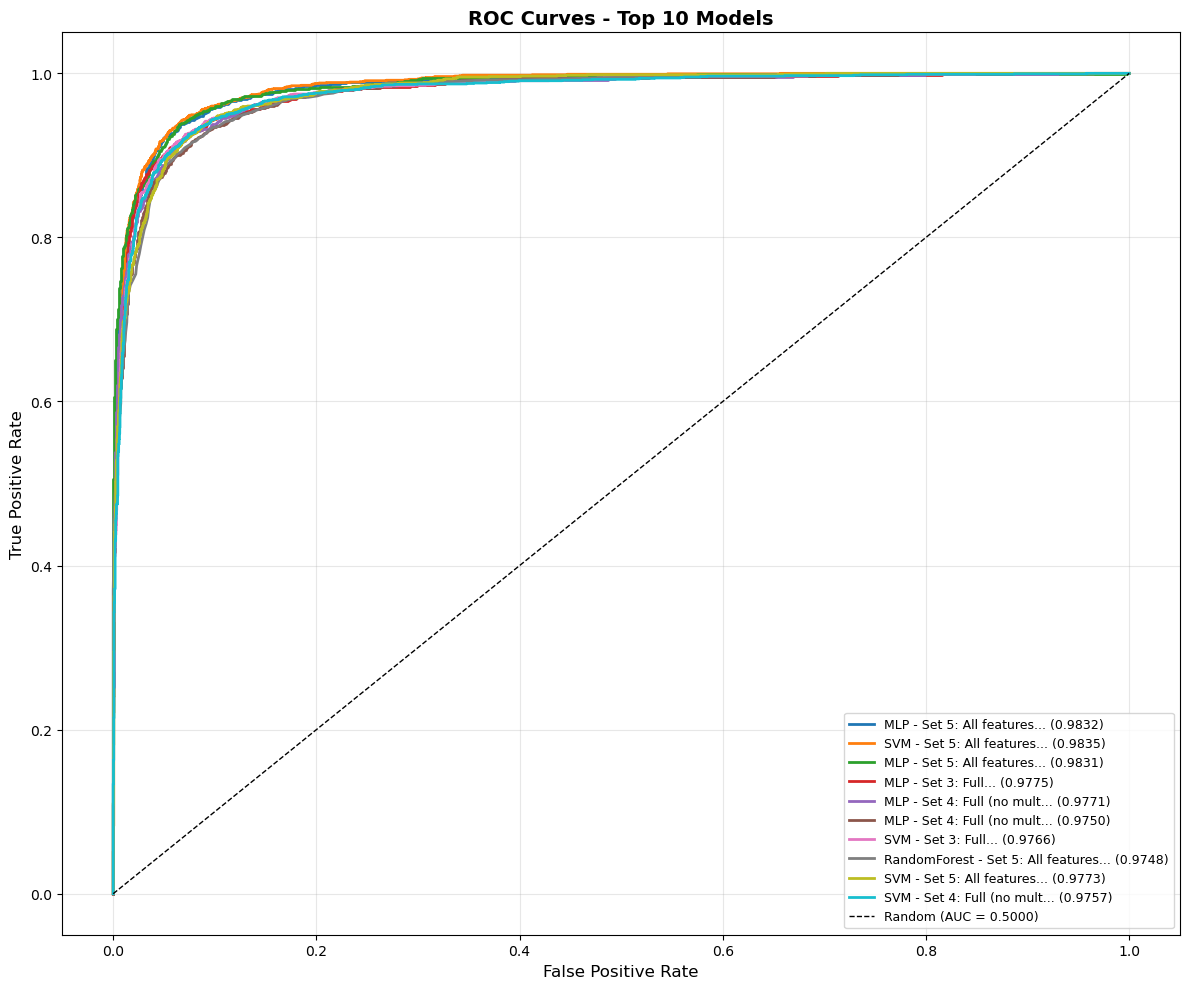

ROC curves plot saved.


In [ ]:
# 2. ROC Curves for Top Models
top_models = results_df.nlargest(10, 'test_accuracy')

fig, ax = plt.subplots(figsize=(12, 10))

for idx, row in top_models.iterrows():
    key = f"{row['model']}_{row['feature_set']}_{row['scaler']}"
    if key in trained_models:
        # Get test predictions
        feature_func = feature_set_funcs[row['feature_set']]
        X_train_fs_temp = feature_func(X_train)
        X_test_fs = feature_func(X_test)
        # Handle NaN (using train for computing medians)
        _, _, X_test_fs = handle_nan_features(X_train_fs_temp, X_test_fs, X_test_fs)
        scaler = trained_scalers[key]
        X_test_scaled = scaler.transform(X_test_fs)
        model = trained_models[key]
        y_proba = model.predict_proba(X_test_scaled)
        
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        label = f"{row['model']} - {row['feature_set'][:20]}... ({roc_auc:.4f})"
        ax.plot(fpr, tpr, label=label, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Top 10 Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'plots' / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC curves plot saved.")

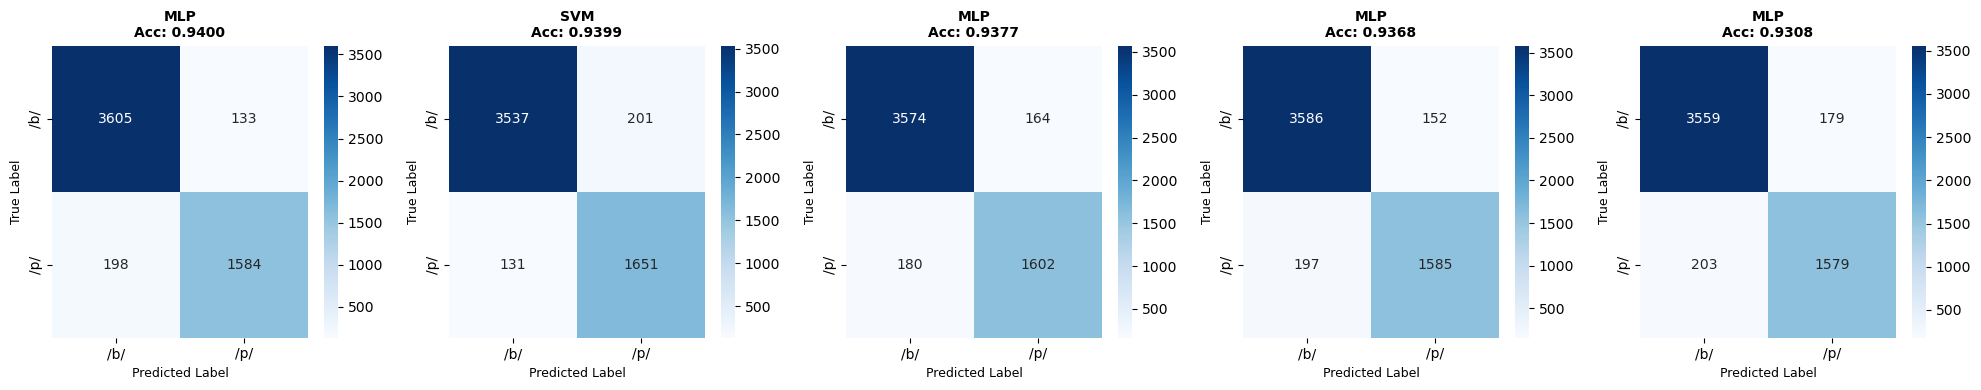

Confusion matrices plot saved.


In [ ]:
# 3. Confusion Matrices for Top 5 Models
top_5 = results_df.nlargest(5, 'test_accuracy')

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (ax, (_, row)) in enumerate(zip(axes, top_5.iterrows())):
    key = f"{row['model']}_{row['feature_set']}_{row['scaler']}"
    if key in trained_models:
        # Get test predictions
        feature_func = feature_set_funcs[row['feature_set']]
        X_train_fs_temp = feature_func(X_train)
        X_test_fs = feature_func(X_test)
        # Handle NaN (using train for computing medians)
        _, _, X_test_fs = handle_nan_features(X_train_fs_temp, X_test_fs, X_test_fs)
        scaler = trained_scalers[key]
        X_test_scaled = scaler.transform(X_test_fs)
        model = trained_models[key]
        y_pred = model.predict(X_test_scaled)
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                   xticklabels=['/b/', '/p/'], yticklabels=['/b/', '/p/'])
        ax.set_title(f"{row['model']}\nAcc: {row['test_accuracy']:.4f}", fontsize=10, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=9)
        ax.set_xlabel('Predicted Label', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'plots' / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices plot saved.")

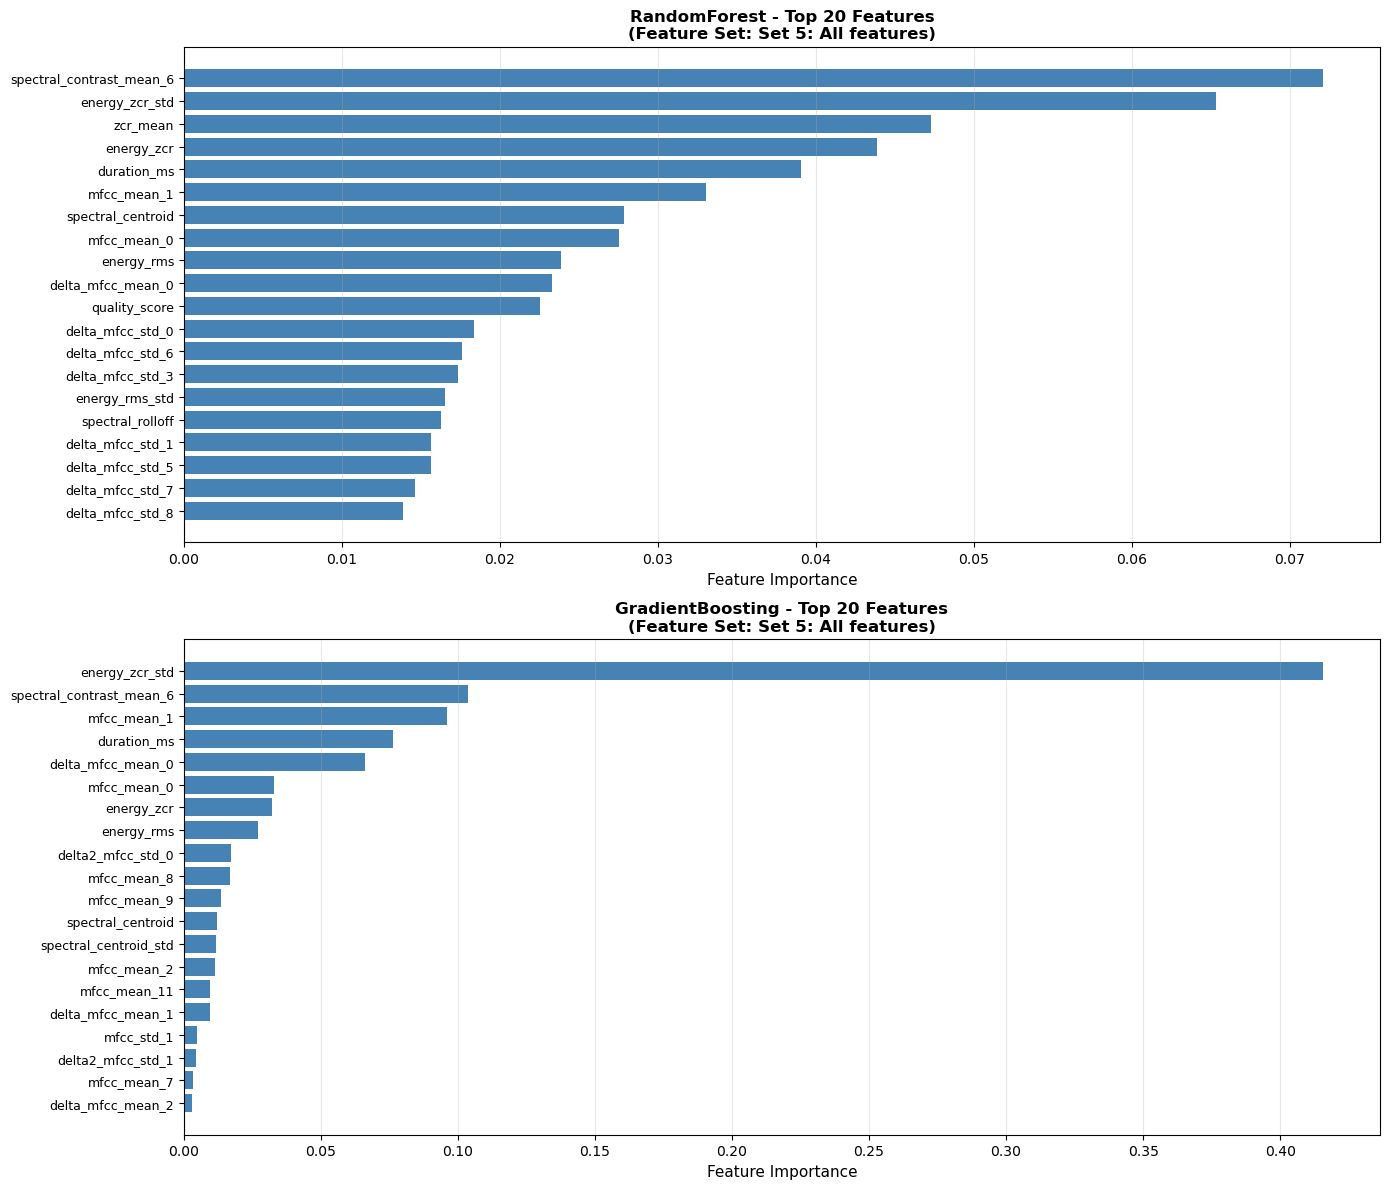

Feature importance plot saved.


In [ ]:
# 4. Feature Importance for Tree-based Models
tree_models = ['RandomForest', 'GradientBoosting']
fig, axes = plt.subplots(len(tree_models), 1, figsize=(14, 6 * len(tree_models)))

if len(tree_models) == 1:
    axes = [axes]

for model_idx, model_name in enumerate(tree_models):
    ax = axes[model_idx]
    
    # Find best model of this type
    model_results = results_df[results_df['model'] == model_name]
    if len(model_results) == 0:
        continue
    
    best_model_row = model_results.nlargest(1, 'test_accuracy').iloc[0]
    key = f"{best_model_row['model']}_{best_model_row['feature_set']}_{best_model_row['scaler']}"
    
    if key in trained_models:
        model = trained_models[key]
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            feature_func = feature_set_funcs[best_model_row['feature_set']]
            X_train_fs = feature_func(X_train)
            feature_names = X_train_fs.columns
            
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:20]  # Top 20
            
            ax.barh(range(len(indices)), importances[indices], color='steelblue')
            ax.set_yticks(range(len(indices)))
            ax.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
            ax.set_xlabel('Feature Importance', fontsize=11)
            ax.set_title(f'{model_name} - Top 20 Features\n(Feature Set: {best_model_row["feature_set"]})', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'plots' / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature importance plot saved.")

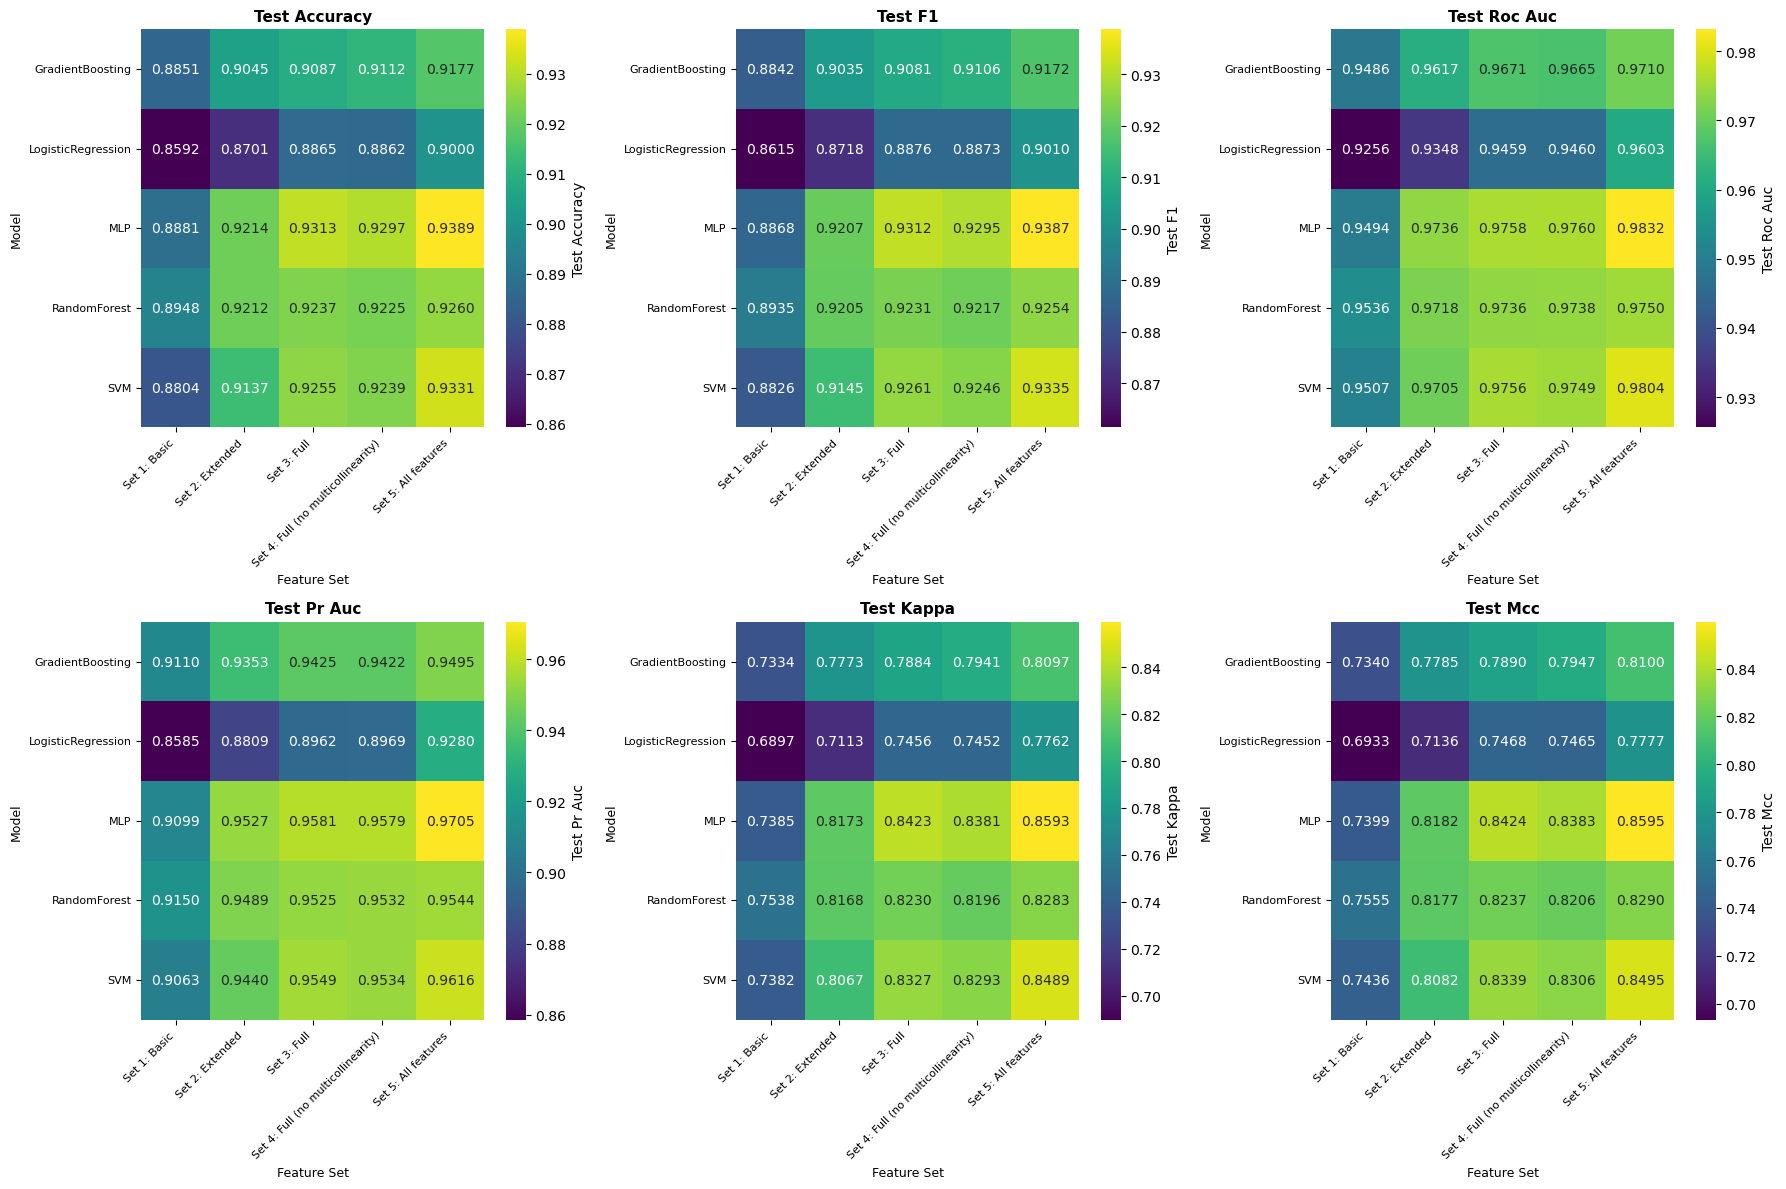

Metrics comparison plot saved.


In [ ]:
# 5. Comprehensive Metrics Comparison
metrics_to_plot = ['test_accuracy', 'test_f1', 'test_roc_auc', 'test_pr_auc', 'test_kappa', 'test_mcc']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Group by model and feature set, take mean across scalers
    metric_data = results_df.groupby(['model', 'feature_set'])[metric].mean().reset_index()
    metric_pivot = metric_data.pivot(index='model', columns='feature_set', values=metric)
    
    sns.heatmap(metric_pivot, annot=True, fmt='.4f', cmap='viridis', ax=ax, 
               cbar_kws={'label': metric.replace('_', ' ').title()})
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature Set', fontsize=9)
    ax.set_ylabel('Model', fontsize=9)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'plots' / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison plot saved.")

## 6. Best Model Selection and Summary

In [ ]:
# Select top 3 models
top_3_models = results_df.nlargest(3, 'test_accuracy')

print("="*80)
print("TOP 3 MODELS")
print("="*80)

for rank, (idx, row) in enumerate(top_3_models.iterrows(), 1):
    print(f"\nRank {rank}:")
    print(f"  Model: {row['model']}")
    print(f"  Feature Set: {row['feature_set']}")
    print(f"  Scaler: {row['scaler']}")
    print(f"  Test Accuracy: {row['test_accuracy']:.4f}")
    print(f"  Test F1: {row['test_f1']:.4f}")
    print(f"  Test ROC-AUC: {row['test_roc_auc']:.4f}")
    print(f"  Test PR-AUC: {row['test_pr_auc']:.4f}")
    print(f"  Test Kappa: {row['test_kappa']:.4f}")
    print(f"  Test MCC: {row['test_mcc']:.4f}")
    print(f"  CV Mean: {row['cv_mean']:.4f} ± {row['cv_std']:.4f}")
    print(f"  Number of Features: {row['n_features']}")

# Create detailed comparison table
comparison_cols = ['model', 'feature_set', 'scaler', 'test_accuracy', 'test_f1', 
                   'test_roc_auc', 'test_pr_auc', 'test_kappa', 'test_mcc', 'cv_mean', 'cv_std']
comparison_df = results_df[comparison_cols].copy()
comparison_df = comparison_df.sort_values('test_accuracy', ascending=False)

comparison_df.to_csv(OUTPUT_DIR / 'results' / 'comparison_table.csv', index=False)
print(f"\nComparison table saved to: {OUTPUT_DIR / 'results' / 'comparison_table.csv'}")
print(f"\nFirst 10 rows:")
print(comparison_df.head(10).to_string(index=False))

TOP 3 MODELS

Rank 1:
  Model: MLP
  Feature Set: Set 5: All features
  Scaler: MinMaxScaler
  Test Accuracy: 0.9400
  Test F1: 0.9397
  Test ROC-AUC: 0.9832
  Test PR-AUC: 0.9699
  Test Kappa: 0.8615
  Test MCC: 0.8618
  CV Mean: 0.9324 ± 0.0049
  Number of Features: 109

Rank 2:
  Model: SVM
  Feature Set: Set 5: All features
  Scaler: StandardScaler
  Test Accuracy: 0.9399
  Test F1: 0.9402
  Test ROC-AUC: 0.9835
  Test PR-AUC: 0.9662
  Test Kappa: 0.8638
  Test MCC: 0.8642
  CV Mean: 0.9371 ± 0.0027
  Number of Features: 109

Rank 3:
  Model: MLP
  Feature Set: Set 5: All features
  Scaler: StandardScaler
  Test Accuracy: 0.9377
  Test F1: 0.9376
  Test ROC-AUC: 0.9831
  Test PR-AUC: 0.9712
  Test Kappa: 0.8571
  Test MCC: 0.8571
  CV Mean: 0.9410 ± 0.0036
  Number of Features: 109

Comparison table saved to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/results/comparison_table.csv

First 10 rows:
       model                        feature_set         scaler  test_accur

## 7. Save Models and Scalers

In [ ]:
# Save top 3 models and their scalers
print("Saving top 3 models...")

for rank, (idx, row) in enumerate(top_3_models.iterrows(), 1):
    key = f"{row['model']}_{row['feature_set']}_{row['scaler']}"
    
    if key in trained_models and key in trained_scalers:
        # Create safe filename
        safe_key = key.replace(' ', '_').replace(':', '_').replace('/', '_')
        
        # Save model
        model_path = OUTPUT_DIR / 'models' / f'{safe_key}_model.joblib'
        joblib.dump(trained_models[key], model_path)
        print(f"  Rank {rank}: Model saved to {model_path}")
        
        # Save scaler
        scaler_path = OUTPUT_DIR / 'scalers' / f'{safe_key}_scaler.joblib'
        joblib.dump(trained_scalers[key], scaler_path)
        print(f"  Rank {rank}: Scaler saved to {scaler_path}")
        
        # Save metadata
        metadata = {
            'rank': rank,
            'model': row['model'],
            'feature_set': row['feature_set'],
            'scaler': row['scaler'],
            'test_accuracy': float(row['test_accuracy']),
            'test_f1': float(row['test_f1']),
            'test_roc_auc': float(row['test_roc_auc']),
            'test_pr_auc': float(row['test_pr_auc']),
            'test_kappa': float(row['test_kappa']),
            'test_mcc': float(row['test_mcc']),
            'cv_mean': float(row['cv_mean']),
            'cv_std': float(row['cv_std']),
            'n_features': int(row['n_features']),
            'model_path': str(model_path),
            'scaler_path': str(scaler_path),
            'timestamp': datetime.now().isoformat()
        }
        
        metadata_path = OUTPUT_DIR / 'models' / f'{safe_key}_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"  Rank {rank}: Metadata saved to {metadata_path}")

print("\nAll models saved successfully!")

Saving top 3 models...
  Rank 1: Model saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/models/MLP_Set_5__All_features_MinMaxScaler_model.joblib
  Rank 1: Scaler saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/scalers/MLP_Set_5__All_features_MinMaxScaler_scaler.joblib
  Rank 1: Metadata saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/models/MLP_Set_5__All_features_MinMaxScaler_metadata.json
  Rank 2: Model saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/models/SVM_Set_5__All_features_StandardScaler_model.joblib
  Rank 2: Scaler saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/scalers/SVM_Set_5__All_features_StandardScaler_scaler.joblib
  Rank 2: Metadata saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/models/SVM_Set_5__All_features_StandardScaler_metadata.json
  Rank 3: Model saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/models/MLP_Set_5__All_features_StandardScaler_mo

## 8. Generate Final Report

In [ ]:
# Generate markdown report
report_lines = [
    "# B-P Phoneme Classification Model Training Report",
    "",
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "## Dataset Summary",
    f"- Total samples: {len(df):,}",
    f"- Training set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)",
    f"- Validation set: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)",
    f"- Test set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)",
    f"- Class distribution (train):",
    f"  - /b/ (0): {np.bincount(y_train)[0]:,} ({np.bincount(y_train)[0]/len(y_train)*100:.1f}%)",
    f"  - /p/ (1): {np.bincount(y_train)[1]:,} ({np.bincount(y_train)[1]/len(y_train)*100:.1f}%)",
    "",
    "## Models Trained",
    f"- Total models: {len(results_df)}",
    f"- Feature sets: {len(feature_set_funcs)}",
    f"- Models: {len(models)}",
    f"- Scalers: {len(scalers_to_test)}",
    "",
    "## Top 3 Models",
    ""
]

for rank, (idx, row) in enumerate(top_3_models.iterrows(), 1):
    report_lines.extend([
        f"### Rank {rank}",
        f"- **Model**: {row['model']}",
        f"- **Feature Set**: {row['feature_set']}",
        f"- **Scaler**: {row['scaler']}",
        f"- **Test Accuracy**: {row['test_accuracy']:.4f}",
        f"- **Test F1**: {row['test_f1']:.4f}",
        f"- **Test ROC-AUC**: {row['test_roc_auc']:.4f}",
        f"- **Test PR-AUC**: {row['test_pr_auc']:.4f}",
        f"- **Test Kappa**: {row['test_kappa']:.4f}",
        f"- **Test MCC**: {row['test_mcc']:.4f}",
        f"- **CV Mean**: {row['cv_mean']:.4f} ± {row['cv_std']:.4f}",
        f"- **Number of Features**: {row['n_features']}",
        ""
    ])

report_lines.extend([
    "## Summary Statistics",
    "",
    "### Best Performance by Metric",
    ""
])

for metric in ['test_accuracy', 'test_f1', 'test_roc_auc', 'test_pr_auc', 'test_kappa', 'test_mcc']:
    best = results_df.nlargest(1, metric).iloc[0]
    report_lines.append(
        f"- **{metric.replace('_', ' ').title()}**: {best[metric]:.4f} "
        f"({best['model']}, {best['feature_set']}, {best['scaler']})"
    )

report_lines.extend([
    "",
    "## Files Generated",
    f"- Results CSV: `{OUTPUT_DIR / 'results' / 'all_results.csv'}`",
    f"- Comparison Table: `{OUTPUT_DIR / 'results' / 'comparison_table.csv'}`",
    f"- Models: `{OUTPUT_DIR / 'models' / '*.joblib'}`",
    f"- Scalers: `{OUTPUT_DIR / 'scalers' / '*.joblib'}`",
    f"- Plots: `{OUTPUT_DIR / 'plots' / '*.png'}`",
    ""
])

# Save report
report_path = OUTPUT_DIR / 'report' / 'training_report.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

print("Report generated:")
print(f"  {report_path}")
print("\nReport preview:")
print('\n'.join(report_lines[:50]))

Report generated:
  /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_models/report/training_report.md

Report preview:
# B-P Phoneme Classification Model Training Report

Generated: 2025-12-19 16:03:19

## Dataset Summary
- Total samples: 36,799
- Training set: 25,773 (70.0%)
- Validation set: 5,506 (15.0%)
- Test set: 5,520 (15.0%)
- Class distribution (train):
  - /b/ (0): 17,451 (67.7%)
  - /p/ (1): 8,322 (32.3%)

## Models Trained
- Total models: 50
- Feature sets: 5
- Models: 5
- Scalers: 2

## Top 3 Models

### Rank 1
- **Model**: MLP
- **Feature Set**: Set 5: All features
- **Scaler**: MinMaxScaler
- **Test Accuracy**: 0.9400
- **Test F1**: 0.9397
- **Test ROC-AUC**: 0.9832
- **Test PR-AUC**: 0.9699
- **Test Kappa**: 0.8615
- **Test MCC**: 0.8618
- **CV Mean**: 0.9324 ± 0.0049
- **Number of Features**: 109

### Rank 2
- **Model**: SVM
- **Feature Set**: Set 5: All features
- **Scaler**: StandardScaler
- **Test Accuracy**: 0.9399
- **Test F1**: 0.9402
- **Test ROC-AUC**: 0.9835
-

## Summary

This notebook implements a comprehensive ML training pipeline for /b/ vs /p/ phoneme classification:

1. **Data Loading**: Loads preprocessed features from `artifacts/b-p_dataset/features/features.parquet`
2. **Feature Sets**: 5 different feature combinations from basic (7 features) to all features (110+)
3. **Normalization**: Tests both StandardScaler and MinMaxScaler
4. **Models**: 5 different algorithms (Logistic Regression, Random Forest, Gradient Boosting, SVM, MLP)
5. **Cross-Validation**: 5-fold CV for each model
6. **Metrics**: Comprehensive evaluation including accuracy, precision, recall, F1, ROC-AUC, PR-AUC, Kappa, MCC
7. **Visualizations**: Accuracy comparisons, ROC curves, confusion matrices, feature importance
8. **Results**: All models, scalers, and results saved for future use

**Total combinations tested**: 5 feature sets × 5 models × 2 scalers = 50 model configurations

All results are saved in `artifacts/b-p_models/` directory.